In [58]:
import pandas as pd
import numpy as np
import scipy as sp
import math

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.metrics import f1_score

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
import lightgbm

from contextlib import contextmanager
import time
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [59]:
def read_df():
    print("Importing datasets...")
    # Read data and merge
    df_train = pd.read_csv('training.csv')
    df_test = pd.read_csv('test.csv')
    
    print("Train shape: {}, Total TransactionId uniques: {}".format(df_train.shape, len(df_train['TransactionId'])))
    print("Test shape: {}, Total TransactionId uniques: {}".format(df_test.shape, len(df_test['TransactionId'])))
    
    df_test['FraudResult'] = np.nan
    df_test.loc[df_test['ProductCategory'] == 'retail', 'ProductCategory'] = 'other'
    df_test.loc[df_test['ChannelId'] == 'ChannelId_4', 'ChannelId'] = 'ChannelId_5'
    df_train['TransactionStartTime'] = pd.to_datetime(df_train.TransactionStartTime)
    df_test['TransactionStartTime'] = pd.to_datetime(df_test.TransactionStartTime)

    return df_train, df_test

    
def dummies(df, list_cols):
    for col in list_cols:
        df_dummies = pd.get_dummies(df[col], drop_first=True, prefix=(str(col)))
        df = pd.concat([df, df_dummies], axis=1)
        
    return df


In [60]:
df_train, df_test = read_df()
df_train.head()

Importing datasets...
Train shape: (95662, 16), Total TransactionId uniques: 95662
Test shape: (45019, 15), Total TransactionId uniques: 45019


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0


In [61]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [62]:
def feature_engineering(df):
    print("Starting Feature Engineering...")
    df['hhh'] = df['TransactionStartTime'].dt.hour
    df['mmm'] = (df.groupby(['CustomerId'])['hhh'].transform('sum') % 24) /  \
        df.groupby(['CustomerId'])['hhh'].transform('count')
    df['nnn'] = (df.groupby(['CustomerId'])['hhh'].transform('var') % 24) /  \
        df.groupby(['CustomerId'])['hhh'].transform('count') 
    df['bbb'] = (df['hhh'] - df['mmm']) / np.sqrt(df['nnn'])
    
    grouped_df = df.groupby('CustomerId')

    def agg(customer_id, trns_start_time, aggregation):
        df_tmp_x = grouped_df.get_group(customer_id).loc[df['TransactionStartTime'] < trns_start_time, 
                                                       'TransactionStartTime']
        df_tmp_y = grouped_df.get_group(customer_id).loc[df['TransactionStartTime'] < trns_start_time, 
                                                       'Amount']
        df_tmp_y = df_tmp_y/(trns_start_time - df_tmp_x).dt.total_seconds()
        
        return df_tmp_y.agg(aggregation)
    
    #df[['AmountSum', 'AmountCount', 'AmountVar']] = \
    #    df.apply (lambda row: agg(row['CustomerId'], row['TransactionStartTime'], ['sum', 'count', 'var']), axis=1)
#    df = df.sort_values(['CustomerId', 'TransactionStartTime'], ascending=[True, True])
#    df[['CustomerId_previous', 'TransactionStartTime_previous', 'Amount_previous']] =\
#        df[['CustomerId', 'TransactionStartTime', 'Amount']].shift(1, axis=0)
#    df['TransactionDeltaTime']= np.where(df['CustomerId'] == df['CustomerId_previous'], 
#                 (df['TransactionStartTime'] - df['TransactionStartTime_previous']).dt.total_seconds(), np.inf)
    #df['AmountDelta']= np.where(df['CustomerId'] == df['CustomerId_previous'], 
    #             (df['Amount'] - df['Amount_previous']), np.inf)
#    df = df.drop(columns=['CustomerId_previous', 'TransactionStartTime_previous', 'Amount_previous'])

    #df['AmountCount'] = df.groupby(['CustomerId', 'ChannelId'])['Amount'].transform('count')
    df['xxx'] = (df['Amount'] - df.groupby(['CustomerId'])['Amount'].transform('mean'))/\
        df.groupby(['CustomerId'])['Amount'].transform('std')
    df['yyy'] = (df['Amount'] - df.groupby(['CustomerId', 'ProductId'])['Amount'].transform('mean'))/\
        df.groupby(['CustomerId', 'ProductId'])['Amount'].transform('std')
#    df['zzz'] = df['Amount'] * np.exp(-df['TransactionDeltaTime']/3600)
#    df['zzz'] = (df['zzz'] - df.groupby(['CustomerId'])['zzz'].transform('mean'))/\
#        df.groupby(['CustomerId'])['zzz'].transform('std')

    #df['yyy'] = df.groupby(['CustomerId'])['Amount'].transform('count')
    #df['zzz'] = (df['TransactionDeltaTime'] - df.groupby(['CustomerId', 'ProductId'])['TransactionDeltaTime'].transform('mean'))/\
    #    df.groupby(['CustomerId', 'ProductId'])['TransactionDeltaTime'].transform('std')
    #df['zzz'] = df['zzz'].apply(np.exp)  
    
    #df['zzz'] = df.groupby(['CustomerId'])['Amount'].skew()
    #df['zzz'] = df.groupby(['CustomerId'])['Amount'].apply(pd.DataFrame.kurt)
    #df['yyy'] = df.groupby(['CustomerId'])['xxx'].transform('var')
    #df['AmountVar'] = df.groupby(['CustomerId', 'ChannelId'])['Amount'].transform('var')
    #df['AmountStd'] = df.groupby(['CustomerId', 'ChannelId'])['Amount'].transform('std')
    #df['f1'] = df.groupby(['ProductId', 'ProductCategory'])['Amount'].transform('mean')
    #df['f2'] = df.groupby(['ProductId', 'ProductCategory'])['Amount'].transform('std')
    #df['f2'] = df.groupby(['CustomerId'])['TransactionDeltaTime'].transform('sum')
    #df['f3'] = df.groupby(['CustomerId'])['TransactionDeltaTime'].transform('var')
    #df['f'] = df['Amount'] / df['TransactionDeltaTime']
    df = df.drop(columns=['nnn', 'mmm',])
  
    df = reduce_mem_usage(df)
    
    return df
    
good_columns = ['Amount', 
                'AmountSum',
                'ProviderId', 'PricingStrategy', 'ProductCategory', 'ChannelId',
                'ProductId',
               ]

In [63]:
def Preprocessing(df):
    print("Starting Preprocessing..")
    # Threshold for removing correlated variables
    threshold = 0.90
    
    # Absolute value correlation matrix
    corr_matrix = df[df['FraudResult'].notnull()].corr().abs()
    
    # Getting the upper triangle of correlations
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Select columns with correlations above threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print('There are %d columns to remove.' % (len(to_drop)))
    print('Columns to drop: ', to_drop)
    
    to_drop.extend(['TransactionStartTime', 'CurrencyCode', 'CountryCode'])
    df = df.drop(columns = to_drop)
    print('Shape after drop high correlated features: ', df.shape)
    print('Remaining columns: ', df.columns)
    
    for f in ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId',]:
        if f in good_columns:
            lbl = LabelEncoder()
            lbl.fit(list(df[f].values))
            df[f] = lbl.transform(list(df[f].values))
            
    df = dummies(df, ['ProviderId', 'PricingStrategy', 'ProductCategory', 'ChannelId',])
    
    return df

In [64]:
def kfold_lightgbm(df, debug= False):
    print("Preparing the datasets...")
    # Divide in training/validation and test data
    train_df = df[df['FraudResult'].notnull()].copy()
    test_df = df[df['FraudResult'].isnull()].copy()
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
    train_id = train_df['TransactionId'].copy()
    test_id = test_df['TransactionId'].copy()
    
    del df
    gc.collect()
    
    train_df = train_df.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId'], axis=1)
    test_df = test_df.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId'], axis=1)
    train_x = train_df.drop('FraudResult', axis=1)
    train_y = train_df['FraudResult']
    test_x = test_df.drop('FraudResult', axis=1) 
    test_df['FraudResult'] = 0.

    def lgb_f1_score(y_hat, data):
        y_true = data.get_label()
        y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
        return 'f1', f1_score(y_true, y_hat), True

    params = {'boosting': 'gbdt', 
              'colsample_bytree': 1, 
              'learning_rate': 0.1, 
              'max_depth': 40, 
              # 'metric': 'auc',
              'min_child_samples': 50, 
              'num_leaves': 500, 
              'objective': 'binary', 
              'reg_alpha': 0.5, 
              'reg_lambda': 0.8, 
              'subsample': 0.5,
              'verbose': 1,
              'is_unbalance': False,
             }
              
    print("Starting the model...") 
    folds = KFold(n_splits=5, shuffle=True, random_state=123)
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_df)):
        trn_x, trn_y = train_x.iloc[trn_idx], train_y.iloc[trn_idx]
        val_x, val_y = train_x.iloc[val_idx], train_y.iloc[val_idx]
        
        lgtrain = lightgbm.Dataset(trn_x, label=trn_y)
        lgval = lightgbm.Dataset(val_x, label=val_y)
 
        model_lgb = lightgbm.train(params, lgtrain, 5000, 
                              valid_sets=[lgtrain, lgval], early_stopping_rounds=250, 
                              verbose_eval=500, feval=lgb_f1_score)
        lightgbm.plot_importance(model_lgb, height=1.0, max_num_features=10)    
        test_df['FraudResult'] += model_lgb.predict(test_x)
        del model_lgb, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print("Creating submission CSV File...")
    # Write submission file and plot feature importance
    if not debug:
        test_submission = "test_submission.csv"
        test_df['TransactionId'] = test_id
        test_df['FraudResult'] = (test_df['FraudResult'] / 5 > 0.5).astype(np.int)
        test_df[['TransactionId', 'FraudResult']].to_csv(test_submission, index= False)
        
    print("CSV Created: Done")    
    
    return test_df[['TransactionId', 'FraudResult']]
 

Importing datasets
Importing datasets...
Train shape: (95662, 16), Total TransactionId uniques: 95662
Test shape: (45019, 15), Total TransactionId uniques: 45019
Importing Datasets:  - done in 1s
Starting Feature Engineering...
Mem. usage decreased to 10.31 Mb (29.4% reduction)
Starting Feature Engineering...
Mem. usage decreased to  5.15 Mb (25.0% reduction)
Data Shape after Feature Engineering:  (140681, 20)
Feature Engineering:  - done in 1s
Starting Preprocessing..
There are 1 columns to remove.
Columns to drop:  ['Value']
Shape after drop high correlated features:  (140681, 16)
Remaining columns:  Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount',
       'PricingStrategy', 'FraudResult', 'hhh', 'bbb', 'xxx', 'yyy'],
      dtype='object')
Shape After Feature Preprocessing:  (140681, 35)
Feature Preprocessing:  - done in 1s
Preparing the datasets...
Starting LightGBM. Train shape

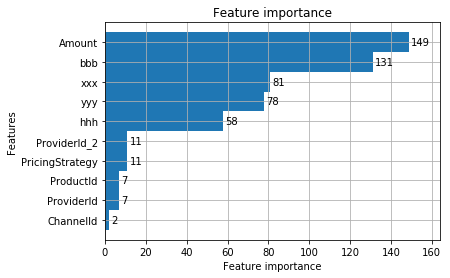

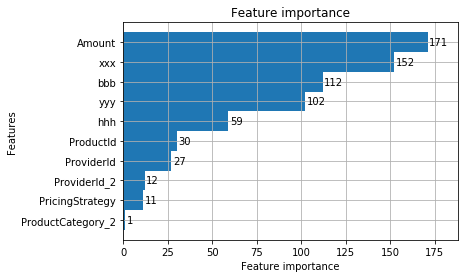

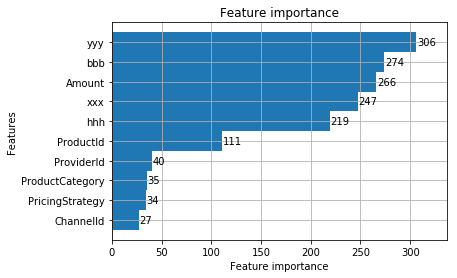

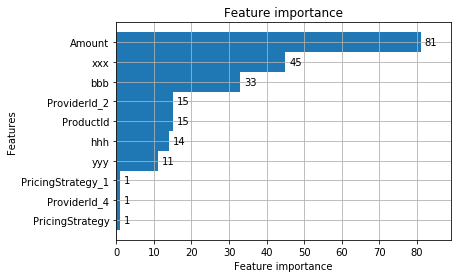

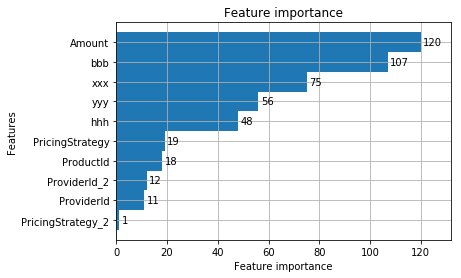

In [65]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0)) 
    
debug = False
p = 0.01 if debug else 1
df = []

with timer("Importing Datasets: "):    
    print("Importing datasets")
    df_train, df_test = read_df()
    gc.collect();

with timer("Feature Engineering: "):
    df_train = feature_engineering(df_train)
    df_test = feature_engineering(df_test)
    df = pd.concat([df_train, df_test])
    print("Data Shape after Feature Engineering: ", df.shape)
    gc.collect();

with timer("Feature Preprocessing: "):
    df = Preprocessing(df)
    print("Shape After Feature Preprocessing: ", df.shape)
    gc.collect()

with timer("Run LightGBM with cross validation"):
    model_prediction = kfold_lightgbm(df, debug= debug)

In [67]:
model_prediction[model_prediction['FraudResult']==1].shape

(75, 2)